Loading in Data, Important for setting label classes

In [15]:
import os
import numpy as np

# Folder where chunked files are stored
folder = "preprocessed_npy"

# Automatically find and sort image/label chunks
image_chunks = sorted([f for f in os.listdir(folder) if f.startswith("images_chunk")])
label_chunks = sorted([f for f in os.listdir(folder) if f.startswith("labels_chunk")])

# Load all chunks into memory
images_all = []
labels_all = []

for img_file, lbl_file in zip(image_chunks, label_chunks):
    images = np.load(os.path.join(folder, img_file))
    labels = np.load(os.path.join(folder, lbl_file))
    images_all.append(images)
    labels_all.append(labels)

# Concatenate into final arrays
images = np.concatenate(images_all, axis=0)
labels = np.concatenate(labels_all, axis=0)

# Load the class names (optional, if saved previously)
label_classes_path = os.path.join(folder, "label_classes.npy")
if os.path.exists(label_classes_path):
    label_classes = np.load(label_classes_path, allow_pickle=True)
else:
    label_classes = np.unique(labels)

label_classes = [label_classes[1], label_classes[0], label_classes[2], label_classes[3]]

# Summary
print("Loaded images:", images.shape)
print("Loaded labels:", labels.shape)
print("Label classes:", list(label_classes))
print("Label classes:", label_classes)


Loaded images: (9208, 224, 224)
Loaded labels: (9208,)
Label classes: [np.str_('Normal'), np.str_('COVID-19'), np.str_('Pneumonia-Bacterial'), np.str_('Pneumonia-Viral')]
Label classes: [np.str_('Normal'), np.str_('COVID-19'), np.str_('Pneumonia-Bacterial'), np.str_('Pneumonia-Viral')]


For Training and Executing a Resnet Model

Using cache found in C:\Users\conno/.cache\torch\hub\pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

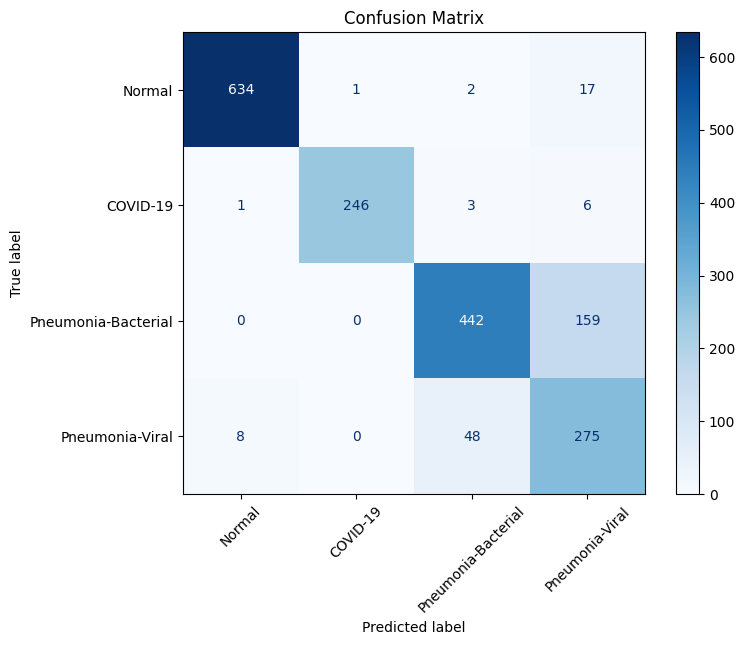

In [37]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import kornia.augmentation as K

# chunked files from pyspark
folder = "preprocessed_npy"
image_chunks = sorted([f for f in os.listdir(folder) if f.startswith("images_chunk")])
label_chunks = sorted([f for f in os.listdir(folder) if f.startswith("labels_chunk")])

# combine chunks
images_all, labels_all = [], []
for img_file, lbl_file in zip(image_chunks, label_chunks):
    images_all.append(np.load(os.path.join(folder, img_file)))
    labels_all.append(np.load(os.path.join(folder, lbl_file)))

images = np.concatenate(images_all, axis=0)
labels = np.concatenate(labels_all, axis=0)


#setting no disease to 0 and covid to 1
#print(type(labels))
#print(labels)
new_labels = []
for i in range(len(labels)):
    if(labels[i]==1):
        new_labels.append(0)
    elif(labels[i]==0):
        new_labels.append(1)
    else:
        new_labels.append(labels[i])

new_labels = np.array(new_labels)
labels = new_labels
#print(type(labels))
#print(labels)

#print(1/0)
# label encoding + weights for balancing
labels_encoded = labels
weights = compute_class_weight("balanced", classes=np.unique(labels_encoded), y=labels_encoded)
num_classes = len(np.unique(labels))
weights_tensor = torch.tensor(weights, dtype=torch.float32)



# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, stratify = labels, random_state=42
#    images, labels, test_size=0.2, stratify=labels, random_state=42
)

# convert to tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# torch datasets + loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

#print(test_dataset[0][1])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=4, pin_memory=True)

# augmentation w/ kornia
augmenter = nn.Sequential(
    K.RandomHorizontalFlip(p=0.5),
    K.RandomRotation(degrees=10.0),
    K.RandomAffine(degrees=0.0, translate=(0.1, 0.1))
).to("cuda")



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_ = torch.tensor([0.], device=device)

model1 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
#print(model)

model1.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#print(model)
#net.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)

#model.conv1 = torch.nn.Conv2d(1,64, kernel_size=(7,7),stride=(2,2),padding=(3,3),bias=False)
model1.fc = torch.nn.Linear(512 * model1.layer1[0].expansion,4, bias=True)
print(model1)

model1 = model1.to(device)


criterion = nn.CrossEntropyLoss(weight=weights_tensor.to(device))
optimizer = optim.Adam(model1.parameters(), lr=0.001)

# loops
for epoch in range(100):
    start = time.time()
    model1.train()
    total_loss = 0

    for inputs, targets in train_loader:
        #print(inputs[0])
        #print(len(inputs[0][0]))
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = augmenter(inputs)

        optimizer.zero_grad()
        outputs = model1(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}, Time: {time.time() - start:.2f}s")


from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# mode eval mode
model1 = model1.to('cpu')

model1.eval()

all_preds = []
all_labels = []

# Disable gradient calculation
start = time.time()

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to("cpu")
        outputs = model1(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())
inf_time = time.time()-start
print("inference time:", inf_time)


print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=[str(c) for c in np.unique(labels)]))
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_classes)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


For Saving Trained Resnet Model

In [ ]:
epochs = 100
layers = 34
PATH = f'./resnet{layers}_{epochs}.pth'
torch.save(model1.state_dict(), PATH)

For Loading Pretrained Resnet Model

In [57]:
epochs = 100
layers = 34
PATH = f'./resnet{layers}_{epochs}.pth'
model1 = torch.hub.load('pytorch/vision:v0.10.0', f'resnet{layers}', pretrained=False)
model1.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model1.fc = torch.nn.Linear(512 * model1.layer1[0].expansion,4, bias=True)
model1.load_state_dict(torch.load(PATH, weights_only=True))

Using cache found in C:\Users\conno/.cache\torch\hub\pytorch_vision_v0.10.0


<All keys matched successfully>

For Executing Loaded Resnet model on Test Data

inference time: 20.86351752281189

 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       654
           1       1.00      0.98      0.99       256
           2       0.91      0.83      0.87       601
           3       0.73      0.82      0.77       331

    accuracy                           0.91      1842
   macro avg       0.90      0.90      0.90      1842
weighted avg       0.91      0.91      0.91      1842



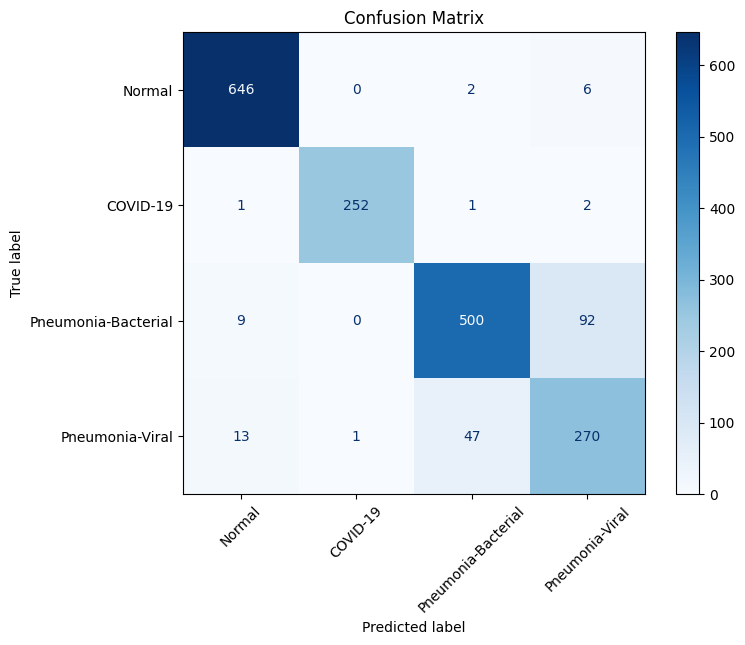

In [58]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import kornia.augmentation as K

# chunked files from pyspark
folder = "preprocessed_npy"
image_chunks = sorted([f for f in os.listdir(folder) if f.startswith("images_chunk")])
label_chunks = sorted([f for f in os.listdir(folder) if f.startswith("labels_chunk")])

# combine chunks
images_all, labels_all = [], []
for img_file, lbl_file in zip(image_chunks, label_chunks):
    images_all.append(np.load(os.path.join(folder, img_file)))
    labels_all.append(np.load(os.path.join(folder, lbl_file)))

images = np.concatenate(images_all, axis=0)
labels = np.concatenate(labels_all, axis=0)


#setting no disease to 0 and covid to 1
#print(type(labels))
#print(labels)
new_labels = []
for i in range(len(labels)):
    if(labels[i]==1):
        new_labels.append(0)
    elif(labels[i]==0):
        new_labels.append(1)
    else:
        new_labels.append(labels[i])

new_labels = np.array(new_labels)
labels = new_labels
#print(type(labels))
#print(labels)

#print(1/0)
# label encoding + weights for balancing
labels_encoded = labels
weights = compute_class_weight("balanced", classes=np.unique(labels_encoded), y=labels_encoded)
num_classes = len(np.unique(labels))
weights_tensor = torch.tensor(weights, dtype=torch.float32)



# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, stratify = labels, random_state=42
#    images, labels, test_size=0.2, stratify=labels, random_state=42
)

# convert to tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# torch datasets + loaders
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

#print(test_dataset[0][1])

test_loader = DataLoader(test_dataset, batch_size=32, num_workers=4, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_ = torch.tensor([0.], device=device)


from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# mode eval mode
model1 = model1.to('cpu')

model1.eval()

all_preds = []
all_labels = []

# Disable gradient calculation
start = time.time()

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to("cpu")
        outputs = model1(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())
inf_time = time.time()-start
print("inference time:", inf_time)


print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=[str(c) for c in np.unique(labels)]))
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_classes)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


For Training and Executing an SVM

[0 1]


C:\Users\conno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


inf_time:  9.501871824264526
0.8295331161780674
0.8075313807531381
0.9682274247491639
0.8806083650190114
[[ 370  276]
 [  38 1158]]


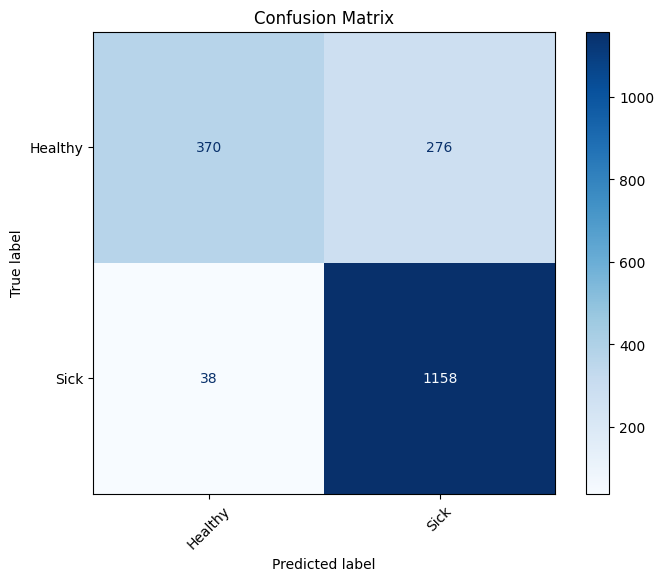

In [ ]:
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

svm_labels = []
for i in range(len(labels)):
    svm_labels.append(int(labels[i]!=0))

nsamples, nx, ny = images.shape
svm_images = images.reshape((nsamples,nx*ny))

svm_labels = np.array(svm_labels)
print(np.unique(svm_labels))


svm_label_classes = np.array(['Healthy', 'Sick'])
# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    svm_images, svm_labels, test_size=0.2, random_state=42
)
svm = SVC(gamma='auto', kernel='rbf', C = 1, max_iter=20)
svm.fit(X_train, y_train)

start = time.time()
preds = svm.predict(X_test)
inf_time = time.time()-start
print('inf_time: ', inf_time)
print(metrics.accuracy_score(y_test, preds))
print(metrics.precision_score(y_test, preds))
print(metrics.recall_score(y_test, preds))
print(metrics.f1_score(y_test, preds))
print(metrics.confusion_matrix(y_test, preds))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_label_classes)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

For Saving an SVM

In [54]:
from pickle import dump
with open("svm.pkl", "wb") as f:
    dump(svm, f, protocol=5)

For Loading an SVM

In [59]:
from pickle import load
with open("svm.pkl", "rb") as f:
    svm = load(f)

For Executing a Loaded SVM

[0 1]
inf_time:  9.655932426452637
0.8295331161780674
0.8075313807531381
0.9682274247491639
0.8806083650190114
[[ 370  276]
 [  38 1158]]


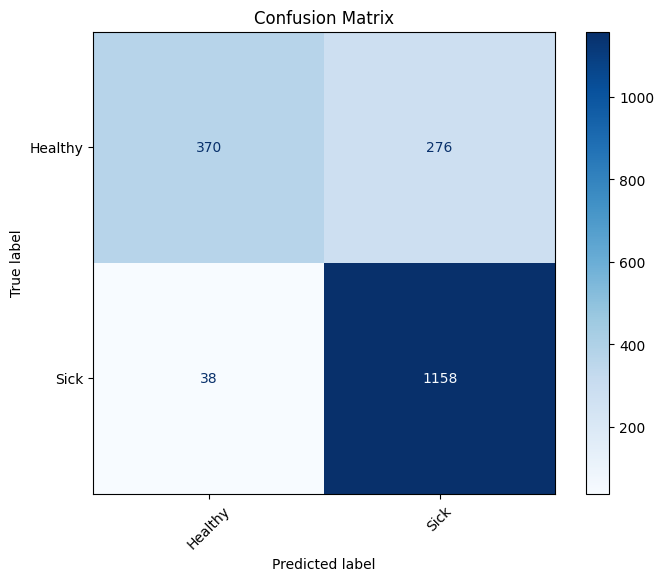

In [61]:
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

svm_labels = []
for i in range(len(labels)):
    svm_labels.append(int(labels[i]!=0))

nsamples, nx, ny = images.shape
svm_images = images.reshape((nsamples,nx*ny))

svm_labels = np.array(svm_labels)
print(np.unique(svm_labels))


svm_label_classes = np.array(['Healthy', 'Sick'])
# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    svm_images, svm_labels, test_size=0.2, random_state=42
)
start = time.time()
preds = svm.predict(X_test)
inf_time = time.time()-start
print('inf_time: ', inf_time)
print(metrics.accuracy_score(y_test, preds))
print(metrics.precision_score(y_test, preds))
print(metrics.recall_score(y_test, preds))
print(metrics.f1_score(y_test, preds))
print(metrics.confusion_matrix(y_test, preds))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_label_classes)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

AN SVM MUST BE EXECUTED BEFORE EACH EXECUTION OF THE HYBRID MODEL

For Executing the Trained Resnet on the Positive Classifications of the SVM

408
408
1434
1434
inference time: 16.37244486808777

 Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       646
           1       1.00      0.87      0.93       299
           2       0.98      0.93      0.96       575
           3       0.89      0.96      0.92       322

    accuracy                           0.95      1842
   macro avg       0.95      0.94      0.94      1842
weighted avg       0.95      0.95      0.95      1842



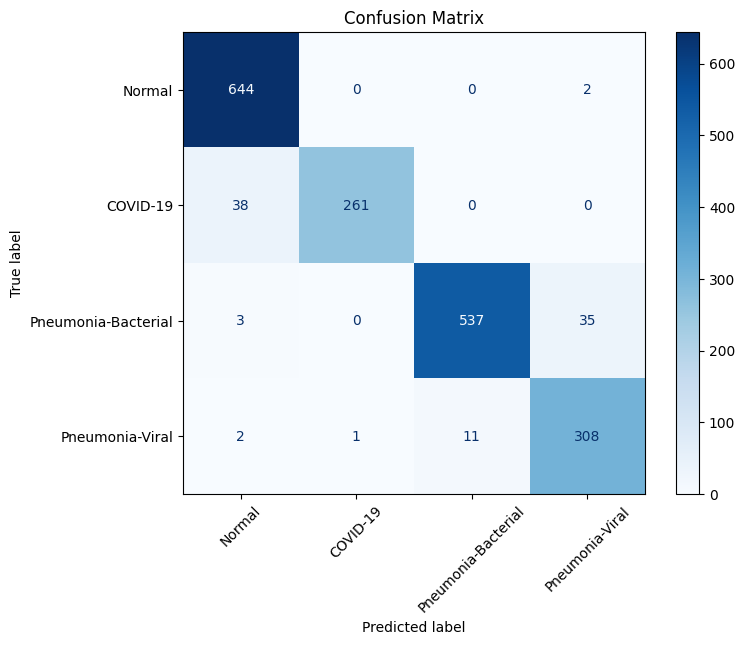

In [62]:
hybrid_test_images = []
hybrid_test_labels = []
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    images, labels, test_size=0.2, random_state=42
)
all_preds = []
all_labels = []
for i in range(len(preds)):
    if preds[i]==1:
        hybrid_test_images.append(X_test2[i])
        hybrid_test_labels.append(y_test2[i])
    else:
        all_preds.append(preds[i])
        all_labels.append(y_test[i])

hybrid_test_images = np.array(hybrid_test_images)
hybrid_test_labels = np.array(hybrid_test_labels)


print(len(all_preds))
print(len(all_labels))
print(len(hybrid_test_images))
print(len(hybrid_test_labels))


X_test_tensor = torch.tensor(hybrid_test_images, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(hybrid_test_labels, dtype=torch.long)

# torch datasets + loaders
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

#print(test_dataset[0][1])
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=4, pin_memory=True)

# augmentation w/ kornia
augmenter = nn.Sequential(
    K.RandomHorizontalFlip(p=0.5),
    K.RandomRotation(degrees=10.0),
    K.RandomAffine(degrees=0.0, translate=(0.1, 0.1))
).to("cuda")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# mode eval mode
model1 = model1.to("cpu")
model1.eval()

start = time.time()

# Disable gradient calculation
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to("cpu")
        outputs = model1(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())
inf_time = time.time()-start

print("inference time:", inf_time)
# classification report
print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=[str(c) for c in np.unique(labels)]))
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_classes)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
